# Abnormality Detection in Bone X-Rays

> *Deep Learning*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

##### *Description*

<p style='text-align: justify;'>Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. You must use at least 2 different architectures, one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and one with a popular pre-trained CNN model (e.g., VGG-19, ResNet, etc.). Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found at <a href="https://stanfordmlgroup.github.io/competitions/mura/">https://stanfordmlgroup.github.io/competitions/mura/</a>. To download the dataset you must first fill out a form.</p>

You can find the Google Colab link [here.](https://colab.research.google.com/drive/1U4A5LiIUstD68YuVE0DrLTPvAuEQVMr4)

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Data*](#data)
    - [*1.3. Data Preparation*](#data_preparation)
    - [*1.4. Data Preprocessing*](#data_preprocessing)
- [*2. VGG-19*](#vgg_19)
    - [*2.1. Model Architecture*](#model_architecture)
    - [*2.2. Metrics*](#metrics)
    - [*2.3. Callbacks*](#callbacks)
    - [*2.4. Model Training*](#model_training)
    - [*2.5. Model Evaluation*](#model_evaluation)

---

# *Introduction* <a class='anchor' id='introduction'></a>

## *Libraries* <a class='anchor' id='libraries'></a>

- *Install any required packages*
- *Import libraries*

##### *Install packages*

In [1]:
!pip install -U tensorflow-addons -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00


##### *Import libraries*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc
import zipfile
from sklearn.model_selection import train_test_split
import time
import random

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras import backend as K # importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model # the class used to create a model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.utils import plot_model

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, cohen_kappa_score

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.11.0


##### *Initialize some variables needed in order to have reproducible experiments*

In [3]:
SEED = 2023
np.random.seed(SEED) # seed for numpy to have reproducible experiments
set_seed(SEED) # seed for Tensorflow to have reproducible experiments

##### *Define a function to clean up the model*

In [4]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

## *Data* <a class='anchor' id='data'></a>

<p style='text-align: justify;'>The MURA dataset is a large-scale dataset of musculoskeletal radiographs that was released by Stanford University in 2017. The acronym "MURA" stands for "musculoskeletal radiographs" and the dataset contains over 40,000 digital X-ray images covering seven different body parts, including the wrist, elbow, shoulder, finger, hip, knee, and ankle.</p>

<p style='text-align: justify;'>The purpose of the MURA dataset is to enable the development of machine learning models that can automatically detect abnormalities in musculoskeletal radiographs. This is a challenging task because abnormalities can be subtle and difficult for even trained human radiologists to detect.</p>

<p style='text-align: justify;'>The MURA dataset has become a popular benchmark for evaluating the performance of deep learning models in musculoskeletal radiograph analysis. It has been used in a number of research studies and competitions to develop and test algorithms for detecting fractures, dislocations, and other abnormalities in X-ray images.</p>

##### *Download MURA dataset*

In [5]:
# download the data in zip format
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

--2023-03-26 13:54:23--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  16.7MB/s    in 3m 14s  

2023-03-26 13:57:37 (16.7 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



##### *Unzip the dataset*

In [6]:
# what's the filename?
filename = 'MURA-v1.1.zip'

# unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

##### *Get the filepath for the training and test sets*

In [7]:
# what's the filepath?
filepath = 'MURA-v1.1'

# get train and test set filepaths
train_set_filepath = os.path.join(filepath, 'train_image_paths.csv')
test_set_filepath = os.path.join(filepath, 'valid_image_paths.csv')

## *Data Preparation* <a class='anchor' id='data_preparation'></a>

*In this step, we will take the following actions:*

- *1. Load training and test data using the filepaths obtained above*
- *2. Split training data into training (80%) and validation (20%) sets*

##### *Define a function to load the data and create any required columns*

In [8]:
def load_data(filepath:str):

    # load data into a dataframe
    df = pd.read_csv(filepath, header=None, names=['image_path'])

    # create a description of the study of each image
    df['description'] = df.image_path.apply(lambda x: '_'.join(x.split('/')[2:5])[3:])

    # get the type of each study (e.g., elbow, shoulder, etc.)
    df['type'] = df.description.apply(lambda x: x.split('_')[0])

    # get the patient code of each study
    df['patient'] = df.description.apply(lambda x: x.split('_')[1])

    # get the code of each study
    df['study'] = df.description.apply(lambda x: x.split('_')[2])

    # get the opinion of each study
    df['opinion'] = df.description.apply(lambda x: x.split('_')[3])

    # create the label
    df['label'] = np.where(df.opinion == 'positive',1,0)

    return df

##### *Load training data*

In [9]:
# load training data
train_set = load_data(train_set_filepath)

# shape
print(f'train_set.shape: {train_set.shape}')

# preview
train_set.head()

train_set.shape: (36808, 7)


,image_path,description,type,patient,study,opinion,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER_patient00001_study1_positive,SHOULDER,patient00001,study1,positive,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER_patient00001_study1_positive,SHOULDER,patient00001,study1,positive,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER_patient00001_study1_positive,SHOULDER,patient00001,study1,positive,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER_patient00002_study1_positive,SHOULDER,patient00002,study1,positive,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER_patient00002_study1_positive,SHOULDER,patient00002,study1,positive,1


##### *Visualize the distribution of normal and abnormal case studies according to each type of the fracture in training set*

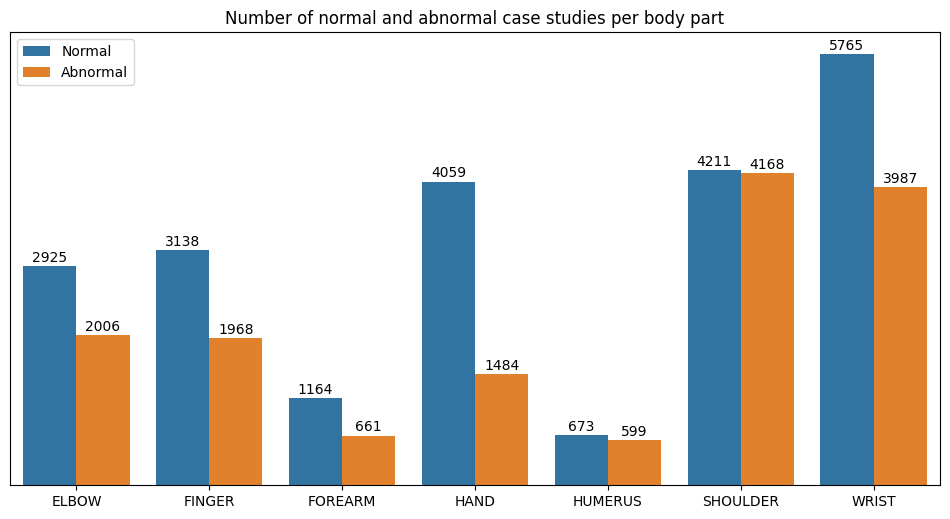

In [10]:
plt.figure(figsize=(12,6),dpi=100)
ax = sns.countplot(data=train_set, x=train_set['type'].sort_values(), hue=train_set['label'])
ax.bar_label(ax.containers[0], padding=1)
ax.bar_label(ax.containers[1], padding=1)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title('Number of normal and abnormal case studies per body part')
plt.legend(loc=0, labels=['Normal','Abnormal'])
plt.savefig('distribution_of_case_studies_per_body_part_train.svg')
plt.show()

##### *Load test data*

In [11]:
# load test data
test_set = load_data(test_set_filepath)

# shape
print(f'test_set.shape: {test_set.shape}')

# preview
test_set.head()

test_set.shape: (3197, 7)


,image_path,description,type,patient,study,opinion,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,WRIST_patient11186_study1_positive,WRIST,patient11186,study1,positive,1


##### *Define a function to split training data into train (80%) and validation (20%) sets*

In [12]:
def train_validation_split(dataset:pd.DataFrame):

    # define x and y
    x = dataset.drop(columns='label')
    y = dataset.label

    # split into training and validation sets
    x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                          y,
                                                          test_size=0.2,
                                                          shuffle=True,
                                                          stratify=dataset[['label','type']],
                                                          random_state=1)
    
    # concat x and y sets
    train_set = pd.concat([x_train, y_train], axis=1)
    valid_set = pd.concat([x_valid, y_valid], axis=1)

    # preview the sizes
    print(f'train_set.shape: {train_set.shape}')
    print(f'valid_set.shape: {valid_set.shape}')

    return train_set, valid_set

##### *Split training data into train (80%) and validation (20%) sets*

In [13]:
# execute function
train_set, valid_set = train_validation_split(train_set)

train_set.shape: (29446, 7)
valid_set.shape: (7362, 7)


##### *Visualize the distribution of the case studies according to each type of the fracture in training and validation sets*

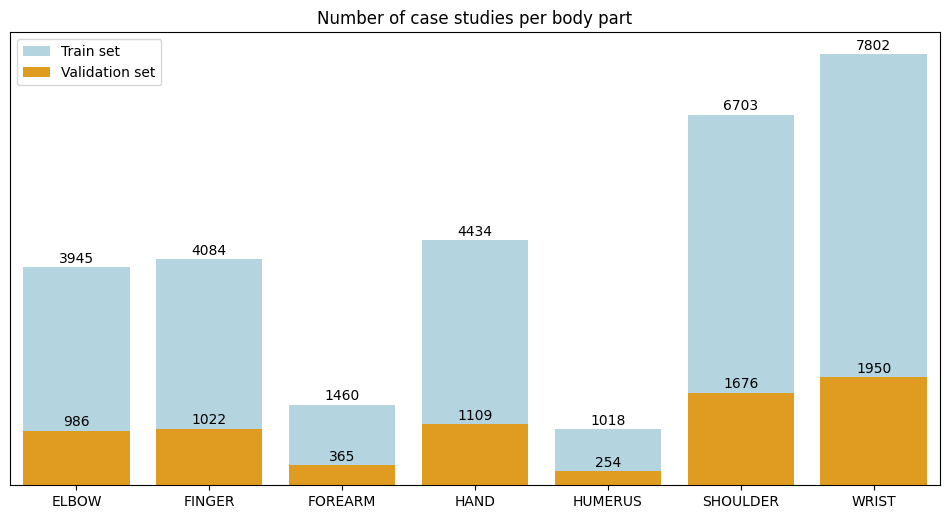

In [14]:
plt.figure(figsize=(12,6),dpi=100)
ax = sns.countplot(data=train_set, x=train_set['type'].sort_values(), color='lightblue', label='Train set')
ax.bar_label(ax.containers[0], padding=1)
ax = sns.countplot(data=valid_set, x=valid_set['type'].sort_values(), color='orange', label='Validation set')
ax.bar_label(ax.containers[1], padding=1)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title('Number of case studies per body part')
plt.legend()
plt.savefig('number_of_case_studies_per_body_part_train.svg')
plt.show()

## *Data Preprocessing* <a class='anchor' id='data_preprocessing'></a>

- *MURA dataset of the bone abnormalities consist of the large variety of the diﬀerent pictures with the diﬀerent formats and sizes*
- *Thus, one of the problems is the necessity to preprocess the images and make the data more homogeneous*
- *For this reason, we will take the following image preprocessing steps*
- *We will resize the images to a consistent size (224x224), since standardizing image size is important for training machine learning models*
- *We will augment the dataset using the following data augmentation approaches:*
  - *Random rotation of the images up to 30 degrees*
  - *Randomly changing brightness in the range 80-120 per cent*
  - *Random flipping the images horizontally*
  - *Randomly scaling in the range 95-130 per cent*
- *In this step, we will use `tf.keras.preprocessing.image.ImageDataGenerator`*
- *This will generate batches of tensor image data with real-time data augmentation*
- *We will apply all the aforementioned transformations only in the training set*
- *The only transformation that we will also apply to both validation and test sets is resizing the image*
- *The reason is to avoid data leakage and introducing bias into the models.*

##### *ImageDataGenerator for training data*

In [15]:
# create ImageDataGenerator object
train_image_data_gen = ImageDataGenerator(
    rotation_range=30,
    brightness_range=(0.8,1.2),
    horizontal_flip=True,
    rescale=random.uniform(0.95,1.3), # select random number between 0.95 and 1.3
    preprocessing_function=preprocess_input
)

# generate images
train_data_gen = train_image_data_gen.flow_from_dataframe(
    train_set,
    x_col='image_path',
    y_col='label',
    target_size=(224,224), # the dimensions to which all images found will be resized
    class_mode='raw', # numpy array of values in y_col column, need to use this if values in y_col are of type int
    batch_size=64, # size of the batches of data
    shuffle=True,
    seed=SEED
)

Found 29446 validated image filenames.


##### *ImageDataGenerator for validation data*

In [16]:
# create ImageDataGenerator object
valid_image_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# generate images
valid_data_gen = valid_image_data_gen.flow_from_dataframe(
    valid_set,
    x_col='image_path',
    y_col='label',
    target_size=(224,224), # the dimensions to which all images found will be resized
    class_mode='raw', # numpy array of values in y_col column, need to use this if values in y_col are of type int
    batch_size=64, # size of the batches of data
    shuffle=True,
    seed=SEED
)

Found 7362 validated image filenames.


##### *ImageDataGenerator for test data*

In [17]:
# create ImageDataGenerator object
test_image_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# generate images
test_data_gen = test_image_data_gen.flow_from_dataframe(
    test_set,
    x_col='image_path',
    y_col='label',
    target_size=(224,224), # the dimensions to which all images found will be resized
    class_mode='raw', # numpy array of values in y_col column, need to use this if values in y_col are of type int
    batch_size=64, # size of the batches of data
    shuffle=False,
    seed=SEED
)

Found 3197 validated image filenames.


# *VGG-19* <a class='anchor' id='vgg_19'></a>

<p style='text-align: justify;'>VGG19 is a deep convolutional neural network architecture for image classification. VGG19 is an extension of the earlier VGG16 model and has 19 layers, hence the name. The VGG19 architecture is based on a series of convolutional layers followed by max-pooling layers, with several fully connected layers at the end. The convolutional layers perform feature extraction by learning increasingly complex filters for detecting patterns in the input images. The max-pooling layers help to reduce the size of the feature maps and provide some level of translation invariance. The fully connected layers at the end perform the classification task by combining the extracted features into class scores.</p>

<p style='text-align: justify;'>One notable aspect of the VGG19 architecture is the use of 3x3 filters in all convolutional layers. This helps to reduce the number of parameters in the model while still maintaining a high level of performance. The VGG19 model has achieved state-of-the-art performance on several benchmark image classification datasets, including the ImageNet dataset.</p>

<p style='text-align: justify;'>Overall, VGG19 is a powerful deep learning architecture that has demonstrated strong performance on image classification tasks. It has been widely used as a pre-trained model for transfer learning and has also been adapted for other computer vision tasks such as object detection and segmentation.</p>

## *Model Architecture* <a class='anchor' id='model_architecture'></a>

- *VGG-19 (without including the 3 fully-connected layers at the top of the network)*
- *Dense Layer (with 512 neurons and ReLU activation function)*
- *Batch Normalization Layer*
- *Dropout Layer (with 20% dropout rate probability)*
- *Output Dense Layer (with Sigmoid activation function)*

##### *Define a function to build a custom Functional model using the pre-trained VGG-19 model*

In [18]:
def build_model(input_shape:tuple=(224,224,3), # input layer shape
                pooling:str='max', # type of pooling to be applied
                hidden_units:int=512, # number of neurons per hidden layer
                hidden_activation:str='relu', # activation function for hidden layer
                hidden_dropout_prob:float=0.2, # dropout probability for neurons in hidden layer
                output_activation:str='sigmoid' # activation function for output layer
               ):
    
    # define the VGG19 model
    base_model = VGG19(
                 include_top=False,
                 weights='imagenet',
                 input_shape=input_shape,
                 pooling=pooling
    )
    
    # get the output
    # of the VGG19 model
    x = base_model.output
    
    # add a dense layer
    x = Dense(
        units=hidden_units,
        kernel_initializer='glorot_uniform',
        activation=hidden_activation,
        name='Dense-1'
    )(x)
    
    # add a batch normalization layer
    x = BatchNormalization(
        name='BatchNormalization-1'
    )(x)
    
    # add a dropout layer
    x = Dropout(
        rate=hidden_dropout_prob,
        name='Dropout-1'
    )(x)
    
    # add the output layer
    output = Dense(
             units=1, # predicted outcome
             kernel_initializer='glorot_uniform',
             activation=output_activation,
             name='Output'
    )(x)
    
    # define the model
    model = Model(inputs=base_model.input, outputs=output)
    
    return base_model, model

## *Metrics* <a class='anchor' id='metrics'></a>

- *We will track the performance of our models using several metrics*
- *In particular, we will use the following ones from `tensorflow.keras.metrics` and `tensorflow_addons.metrics` libraries:*
  - *Precision*
  - *Recall*
  - *F1 Score*
  - *Accuracy*
  - *AUC ROC*
  - *Cohen's Kappa*
- *However, the `tensorflow_addons.metrics.F1Score` seems to be inconsistent with the format of our data and the rest of the metrics*
- *Therefore, we will create a class and define the metric from scratch*
- *An explanation of each of the metrics can be found below:*

##### ***Precision***
- *It answers the question "How many of the predicted images had actually abnormalities?"*
- *It is the fraction of True Positives over all positive predictions*
- *It is used to evaluate how well the model is at correctly identifying positive instances*

##### ***Recall***
- *It answers the question "How many of the images that had actually abnormalities the model predicted right?"*
- *It is the fraction of True Positives over all actual positives instances*
- *It is used to evaluate how well the model is at identifying all positive instances, including those that are false negatives*

##### ***F1 Score***
- *It is the harmonic mean of precision and recall*
- *It is used to evaluate the overall performance of the model on a binary classification task*

##### ***Accuracy***
- *It measures the proportion of correct predictions made by the model over all predictions*
- *It is calculated by dividing the number of correct predictions by the total number of predictions made*

##### ***AUC ROC***
- *It measures the ability of a binary classification model to distinguish between positive and negative classes*
- *It is calculated by plotting the TPR against the FPR at different threshold levels and calculating the area under the resulting curve*
- *The TPR (also known as recall) is the ratio of True Positive predictions to the total number of positive samples*
- *The FPR is the ratio of False Positive predictions to the total number of negative samples*

##### ***Cohen's Kappa***
- *It evaluates the performance of a classification model by comparing its predicted labels with the true labels assigned by human annotators*
- *It measures the degree of agreement between the predicted and true labels*
- *A score of 1 indicates perfect agreement between the model's predictions and the true labels*
- *A score of 0 indicates no agreement beyond what would be expected by chance*

##### *Create a class to track F1 Score*

In [19]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

##### *Define metrics*

In [20]:
# define metrics to track
METRICS = [Precision(name='precision'),
           Recall(name='recall'),
           F1Score(name='f1_score'),
           BinaryAccuracy(name='bin_accuracy'),
           AUC(name='auc_roc'),
           CohenKappa(name='cohen_kappa', num_classes=2)]

## *Callbacks* <a class='anchor' id='callbacks'></a>

- *We will also use callbacks to gain a little more control over the training process*
- *In particular, we will use two callbacks, `EarlyStopping` and `ReduceLROnPlateau`*
- *`EarlyStopping` will help monitor the progress of the training and stop it in case there is no progress over a few epochs*
- *`ReduceLROnPlateau` will monitor the progress of the training and change the learning rate in case there is no progress over a few epochs*

##### *Define callbacks*

In [21]:
# define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1)

# define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    mode='min',
    factor=0.1,
    min_lr=1e-10,
    verbose=1)

# define callbacks
CALLBACKS = [early_stopping, reduce_lr]

## *Model Training* <a class='anchor' id='model_training'></a>

- *In this step, we will train our model*
- *First, we will freeze the VGG-19 model and train only the upper layers for a few epochs*
- *We will use the following params for the upper layers:*
  - *Batch size = 8*
  - *Learning rate = 0.001*
  - *Epochs = 5*
- *Then, we will unfreeze the VGG-19 model and train the full network*
- *We will use the following params for the full network:*
  - *Batch size = 8*
  - *Learning rate = 0.0001*
  - *Epochs = 10*

##### *Define a function to train the model*

In [22]:
def train_model(train_data, # contains both x_train and y_train
                valid_data, # contains both x_valid and y_valid
                input_shape:tuple=(224,224,3), # input layer shape
                pooling:str='max', # type of pooling to be applied
                hidden_units:int=512, # number of neurons per hidden layer
                hidden_activation:str='relu', # activation function for hidden layer
                hidden_dropout_rate:float=0.2, # dropout probability for neurons in hidden layer
                output_activation:str='sigmoid', # activation function for output layer
                upper_layers_learning_rate:float=1e-4,
                full_network_learning_rate:float=1e-5, 
                metrics:list=['accuracy'],
                batch_size:int=8,
                upper_layers_epochs=5,
                full_network_epochs=15,
                verbose:int=1,
                callbacks:list=None
               ):
    
    # build the model
    base_model, model = build_model(input_shape,
                                    pooling,
                                    hidden_units,
                                    hidden_activation,
                                    hidden_dropout_rate,
                                    output_activation
                                   )
    
    # first train the upper layers for a few epochs
    for layer in base_model.layers:
        layer.trainable = False

    # compile and train the model
    model.compile(optimizer=Adam(learning_rate=upper_layers_learning_rate), loss='binary_crossentropy', metrics=metrics)
    hs_upper_layers = model.fit(x=train_data,
                                batch_size=batch_size,
                                epochs=upper_layers_epochs,
                                verbose=verbose,
                                callbacks=callbacks,
                                validation_data=valid_data
                               )
    
    # upper layers training message
    print()
    print('Finished training upper layers.')
    print('-------------------------------')
    print()

    # now train the whole network with a low learning rate
    for layer in base_model.layers:
        layer.trainable = True

    # compile and train the model
    model.compile(optimizer=Adam(learning_rate=full_network_learning_rate), loss='binary_crossentropy', metrics=metrics)
    hs_full_network = model.fit(x=train_data,
                                batch_size=batch_size,
                                epochs=full_network_epochs,
                                verbose=verbose,
                                callbacks=callbacks,
                                validation_data=valid_data
                               )
    
    # full network training message
    print()
    print('Finished training full network.')
    print('-------------------------------')
    print()

    return model, hs_upper_layers, hs_full_network

##### *Train the model*

In [24]:
# start time
st = time.time()

# execute function to train the model
model, hs_upper_layers, hs_full_network = train_model(train_data=train_data_gen,
                                                      valid_data=valid_data_gen,
                                                      metrics=METRICS,
                                                      upper_layers_epochs=5,
                                                      full_network_epochs=5,
                                                      callbacks=CALLBACKS
                                                     )

# end time
et = time.time()

print(f'Elapsed time: {int(et-st)} secs.')

Epoch 1/5
461/461 [==============================] - 574s 1s/step - loss: 0.7014 - precision: 0.5370 - recall: 0.5430 - f1_score: 0.5400 - bin_accuracy: 0.6261 - auc_roc: 0.6573 - cohen_kappa: 0.2251 - val_loss: 0.6089 - val_precision: 0.6905 - val_recall: 0.3990 - val_f1_score: 0.5058 - val_bin_accuracy: 0.6849 - val_auc_roc: 0.7313 - val_cohen_kappa: 0.2980 - lr: 1.0000e-04
Epoch 2/5
461/461 [==============================] - 575s 1s/step - loss: 0.6223 - precision: 0.6176 - recall: 0.5380 - f1_score: 0.5750 - bin_accuracy: 0.6787 - auc_roc: 0.7198 - cohen_kappa: 0.3187 - val_loss: 0.5787 - val_precision: 0.6508 - val_recall: 0.5708 - val_f1_score: 0.6082 - val_bin_accuracy: 0.7028 - val_auc_roc: 0.7527 - val_cohen_kappa: 0.3704 - lr: 1.0000e-04
Epoch 3/5
461/461 [==============================] - 594s 1s/step - loss: 0.6065 - precision: 0.6374 - recall: 0.5460 - f1_score: 0.5882 - bin_accuracy: 0.6911 - auc_roc: 0.7323 - cohen_kappa: 0.3433 - val_loss: 0.5771 - val_precision: 0.6778

##### *Preview model summary*

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

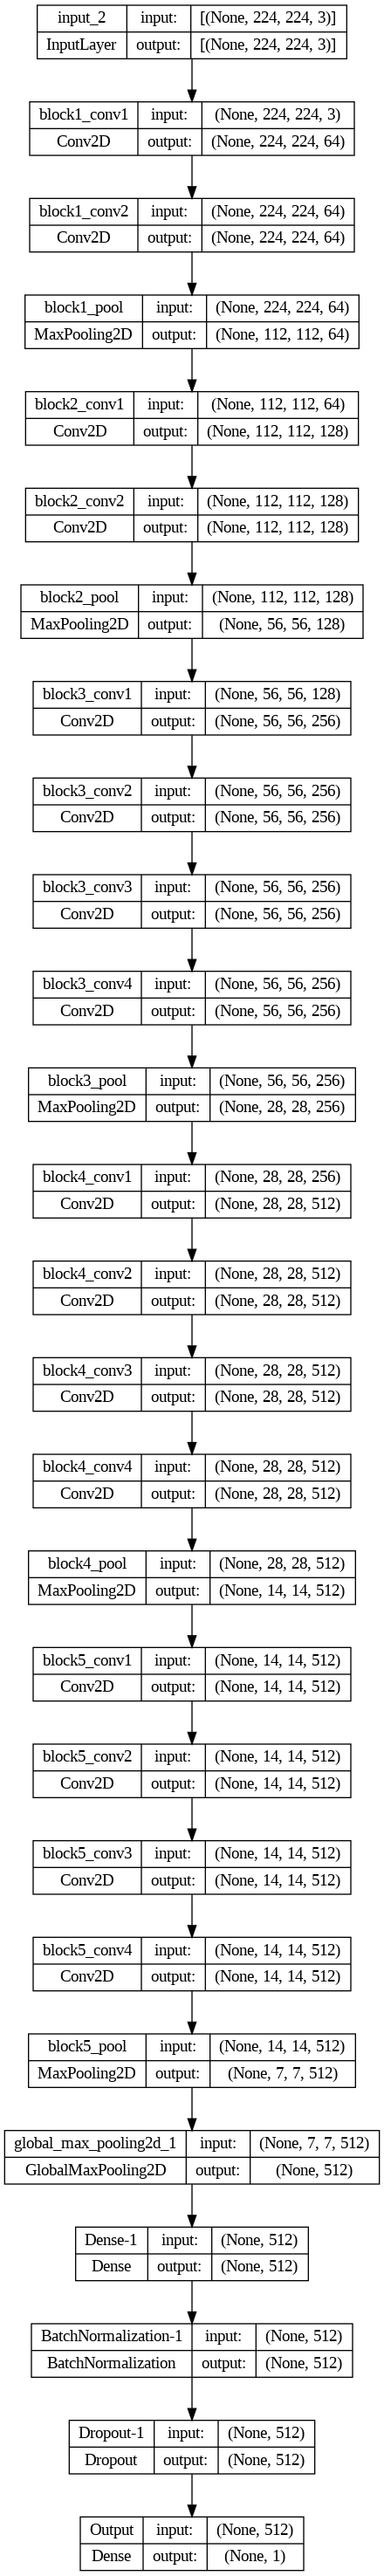

In [26]:
plot_model(model, to_file='vgg19_model.png', show_shapes=True, show_layer_names=True)

## *Model Evaluation* <a class='anchor' id='model_evaluation'></a>

- *In this step, we will evaluate the performance of our model*
- *In particular, we will evaluate its performance both during the training phase and making predictions*
- *For this reason, we will create a function which will help us to plot the learning curves*

##### *Define a function to plot learning curves*

In [27]:
def plot_history(hs, epochs, metric, max_y):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(
            np.arange(hs[label]['x_start'], hs[label]['x_start'] + len(hs[label]['history'].history[metric])),
            hs[label]['history'].history[metric],
            label=f'{label} train {metric}',
            linewidth=2
        )
        plt.plot(
            np.arange(hs[label]['x_start'], hs[label]['x_start'] + len(hs[label]['history'].history[metric])),
            hs[label]['history'].history[f'val_{metric}'],
            label=f'{label} validation {metric}',
            linewidth=2
        )
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks[0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, max_y))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

##### *Evaluation on training and validation data*

In [28]:
epochs=20

Upper Layers Evaluation:
---
Train Loss     : 0.58061
Validation Loss: 0.57035
---
Train Accuracy     : 0.70543
Validation Accuracy: 0.71271
---
Train AUC ROC     : 0.75295
Validation AUC ROC: 0.76568
---
Train Cohen's Kappa     : 0.37319
Validation Cohen's Kappa: 0.36093

Full Network Evaluation:
---
Train Loss     : 0.47878
Validation Loss: 0.56141
---
Train Accuracy     : 0.78330
Validation Accuracy: 0.75048
---
Train AUC ROC     : 0.83944
Validation AUC ROC: 0.82886
---
Train Cohen's Kappa     : 0.53846
Validation Cohen's Kappa: 0.43384



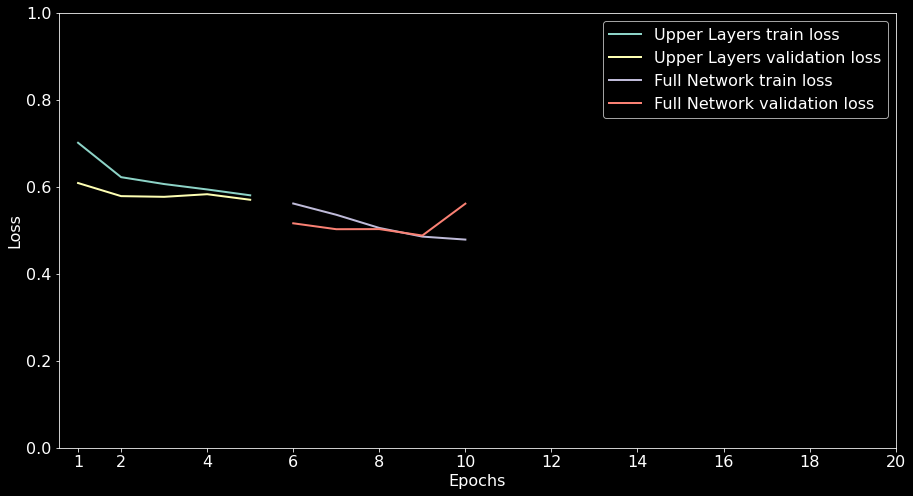

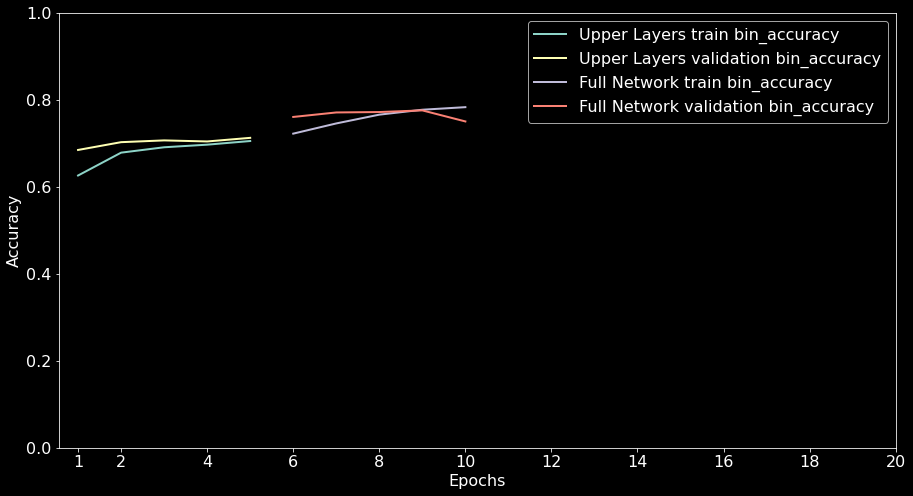

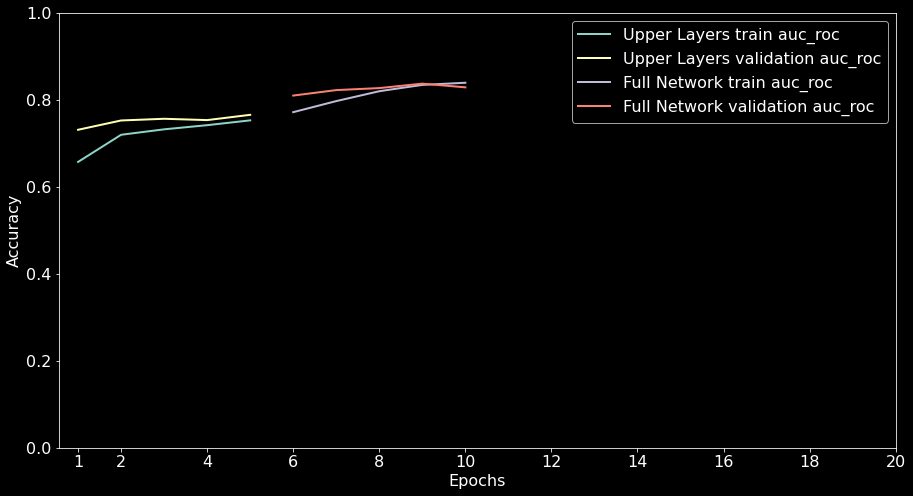

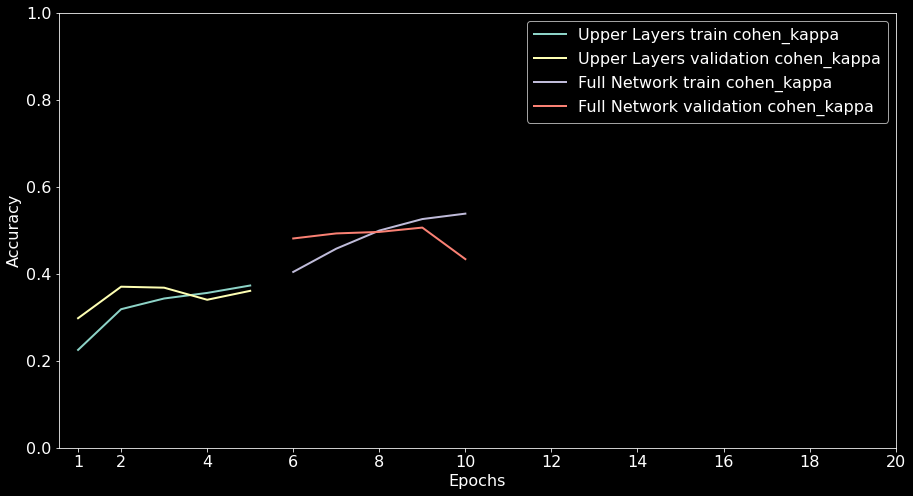

In [31]:
print("Upper Layers Evaluation:")
print("---")
print("Train Loss     : {0:.5f}".format(hs_upper_layers.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hs_upper_layers.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hs_upper_layers.history['bin_accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(hs_upper_layers.history['val_bin_accuracy'][-1]))
print("---")
print("Train AUC ROC     : {0:.5f}".format(hs_upper_layers.history['auc_roc'][-1]))
print("Validation AUC ROC: {0:.5f}".format(hs_upper_layers.history['val_auc_roc'][-1]))
print("---")
print("Train Cohen's Kappa     : {0:.5f}".format(hs_upper_layers.history['cohen_kappa'][-1]))
print("Validation Cohen's Kappa: {0:.5f}".format(hs_upper_layers.history['val_cohen_kappa'][-1]))
print()
print("Full Network Evaluation:")
print("---")
print("Train Loss     : {0:.5f}".format(hs_full_network.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hs_full_network.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hs_full_network.history['bin_accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(hs_full_network.history['val_bin_accuracy'][-1]))
print("---")
print("Train AUC ROC     : {0:.5f}".format(hs_full_network.history['auc_roc'][-1]))
print("Validation AUC ROC: {0:.5f}".format(hs_full_network.history['val_auc_roc'][-1]))
print("---")
print("Train Cohen's Kappa     : {0:.5f}".format(hs_full_network.history['cohen_kappa'][-1]))
print("Validation Cohen's Kappa: {0:.5f}".format(hs_full_network.history['val_cohen_kappa'][-1]))

# plot train and validation error per epoch
plot_history(
    hs={
        'Upper Layers': {'history': hs_upper_layers, 'x_start': 1},
        'Full Network': {'history': hs_full_network, 'x_start': len(hs_upper_layers.history['loss']) + 1}
    },
    epochs=epochs,
    metric='loss',
    max_y=1
)
plot_history(
    hs={
        'Upper Layers': {'history': hs_upper_layers, 'x_start': 1},
        'Full Network': {'history': hs_full_network, 'x_start': len(hs_upper_layers.history['bin_accuracy']) + 1}
    },
    epochs=epochs,
    metric='bin_accuracy',
    max_y=1
)
plot_history(
    hs={
        'Upper Layers': {'history': hs_upper_layers, 'x_start': 1},
        'Full Network': {'history': hs_full_network, 'x_start': len(hs_upper_layers.history['auc_roc']) + 1}
    },
    epochs=epochs,
    metric='auc_roc',
    max_y=1
)
plot_history(
    hs={
        'Upper Layers': {'history': hs_upper_layers, 'x_start': 1},
        'Full Network': {'history': hs_full_network, 'x_start': len(hs_upper_layers.history['cohen_kappa']) + 1}
    },
    epochs=epochs,
    metric='cohen_kappa',
    max_y=1
)

##### *Evaluation on test data*

In [32]:
# evaluate on test data
model_eval = model.evaluate(test_data_gen, verbose=2)

# print results
print()
print("Test Loss         : {0:.5f}".format(model_eval[0]))
print("Test Precision    : {0:.5f}".format(model_eval[1]))
print("Test Recall       : {0:.5f}".format(model_eval[2]))
print("Test F1-Score     : {0:.5f}".format(model_eval[3]))
print("Test Accuracy     : {0:.5f}".format(model_eval[4]))
print("Test Cohen's Kappa: {0:.5f}".format(model_eval[5]))

50/50 - 27s - loss: 0.6136 - precision: 0.9202 - recall: 0.4444 - f1_score: 0.5994 - bin_accuracy: 0.7157 - auc_roc: 0.8364 - cohen_kappa: 0.4179 - 27s/epoch - 532ms/step

Test Loss         : 0.61363
Test Precision    : 0.92016
Test Recall       : 0.44444
Test F1-Score     : 0.59938
Test Accuracy     : 0.71567
Test Cohen's Kappa: 0.83637


##### *Evaluation On Each Study Type*

In [33]:
# make predictions
predictions = model.predict(test_data_gen)

50/50 [==============================] - 21s 409ms/step


##### *Define a function to evaluate the predictions for each study type*

In [34]:
def evaluate_each_study_type(test_set, predictions):

    # append predictions to the test set
    test_set['predictions'] = predictions.ravel()
    test_set['predictions'] = np.where(test_set.predictions >= 0.5,1,0)

    # list of distinct study types
    study_types = sorted(test_set['type'].unique().tolist())

    # loop through study types
    for i, st in enumerate(study_types):

        # keep records of the current study type
        df_t = test_set[test_set['type']==st]

        # evaluate model performance on the current study type
        precision = precision_score(df_t.label.values, df_t.predictions.values)
        recall = recall_score(df_t.label.values, df_t.predictions.values)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = accuracy_score(df_t.label.values, df_t.predictions.values)
        roc_auc = roc_auc_score(df_t.label.values, df_t.predictions.values)
        cohen_kappa = cohen_kappa_score(df_t.label.values, df_t.predictions.values)

        # print results
        print(f"{i+1} - Study Type: {st}")
        print("------------------------")
        print(f"    Precision: {round(precision,5)}")
        print(f"       Recall: {round(recall,5)}")
        print(f"     F1 Score: {round(f1_score,5)}")
        print(f"     Accuracy: {round(accuracy,5)}")
        print(f"      ROC AUC: {round(roc_auc,5)}")
        print(f"Cohen's Kappa: {round(cohen_kappa,5)}")
        print("========================")
        print()

In [35]:
evaluate_each_study_type(test_set, predictions)

1 - Study Type: ELBOW
------------------------
    Precision: 0.96748
       Recall: 0.51739
     F1 Score: 0.67422
     Accuracy: 0.75269
      ROC AUC: 0.75019
Cohen's Kappa: 0.50286

2 - Study Type: FINGER
------------------------
    Precision: 0.92308
       Recall: 0.38866
     F1 Score: 0.54701
     Accuracy: 0.6551
      ROC AUC: 0.67564
Cohen's Kappa: 0.33627

3 - Study Type: FOREARM
------------------------
    Precision: 0.98507
       Recall: 0.43709
     F1 Score: 0.6055
     Accuracy: 0.71429
      ROC AUC: 0.71521
Cohen's Kappa: 0.42962

4 - Study Type: HAND
------------------------
    Precision: 0.84
       Recall: 0.22222
     F1 Score: 0.35146
     Accuracy: 0.66304
      ROC AUC: 0.59635
Cohen's Kappa: 0.21683

5 - Study Type: HUMERUS
------------------------
    Precision: 0.8835
       Recall: 0.65
     F1 Score: 0.74897
     Accuracy: 0.78819
      ROC AUC: 0.78446
Cohen's Kappa: 0.57301

6 - Study Type: SHOULDER
------------------------
    Precision: 0.86395
  

---

*Thank you!*

---